In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mlforecast import MLForecast

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

In [21]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [22]:
df_brl = pd.read_parquet('../../../data/all_comm/all_commodities_brl.parquet')

In [23]:
df_brl.head()

,ds,y,unique_id
0,2020-01-02,65.40,ACUCAR_SANTOS
1,2020-01-03,66.80,ACUCAR_SANTOS
2,2020-01-06,68.92,ACUCAR_SANTOS
3,2020-01-07,68.85,ACUCAR_SANTOS
4,2020-01-08,68.32,ACUCAR_SANTOS


In [24]:
df_brl.tail()

,ds,y,unique_id
59356,2025-04-24,1476.85,TRIGO_RS
59357,2025-04-25,1476.85,TRIGO_RS
59358,2025-04-28,1483.36,TRIGO_RS
59359,2025-04-29,1473.82,TRIGO_RS
59360,2025-04-30,1471.23,TRIGO_RS


In [25]:
df_brl['unique_id'].unique()

array(['ACUCAR_SANTOS', 'ACUCAR_SP', 'ALGODAO', 'ARROZ', 'CAFE_ARABICA',
       'CAFE_ROBUSTA', 'MILHO', 'SOJA_PARANA', 'SOJA_PARANAGUA',
       'TRIGO_PARANA', 'TRIGO_RS'], dtype=object)

In [26]:
df_brl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59361 entries, 0 to 59360
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         59361 non-null  datetime64[ns]
 1   y          59361 non-null  float64       
 2   unique_id  59361 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ MB


In [28]:
train, val, test = split_series(df_brl)

Splitted data into TRAIN with size 33235, VALIDATION with size 8312 and TEST with size 17814


In [ ]:
model = make_pipeline(
    StandardScaler(), 
    SVR(
        C=10.0,
        gamma=0.5,
        epsilon=0.25
    )
)

fcst = MLForecast(
    models={'svr': model},
    lags=[1, 2],
    freq='D'
)

# params found here https://www.nature.com/articles/s41598-024-74503-4/tables/7

In [11]:
# start tunning here if needed eventually

In [12]:
full_train = pd.concat([train, val])

In [13]:
fcst.fit(full_train)

MLForecast(models=[svr], freq=D, lag_features=['lag1', 'lag2'], date_features=[], num_threads=1)

In [14]:
# Rollout
forecasts = []
for i in range(len(test)):
    f_next = fcst.predict(h=1)
    forecasts.append(f_next)

    # add real value
    obs = test.iloc[[i]][['unique_id', 'ds', 'y']]
    fcst.update(obs)

In [15]:
forecasts_df = pd.concat(forecasts, ignore_index=True)

In [16]:
evaluator = MetricEvaluator()

In [17]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['svr'],         
    groupby_column='unique_id'     
)

print(results)

         unique_id Model  n_observations         MAE      MAPE            MSE  \
0    ACUCAR_SANTOS   svr             306    2.051402  0.013536       6.857422   
1        ACUCAR_SP   svr            1657    0.619327  0.005454       0.943264   
2          ALGODAO   svr            3696    1.457625  0.004201       5.875897   
3            ARROZ   svr            5335    0.254512  0.004725       0.141844   
4     CAFE_ROBUSTA   svr            9184   22.459930  0.016327   25040.910585   
5            MILHO   svr           10784    0.725492  0.017311       0.555014   
6      SOJA_PARANA   svr           12740    1.512909  0.020642       2.453346   
7     TRIGO_PARANA   svr           15868   60.780981  0.039590   64736.068643   
8         TRIGO_RS   svr           17455   48.573485  0.033209   47461.988562   
9     CAFE_ARABICA   svr            1654  263.038524  0.166280  317889.246271   
10  SOJA_PARANAGUA   svr            1106    1.149827  0.007671       2.621610   

          RMSE        R2  


In [18]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)


=== Estatísticas Resumo ===
           MAE                                       MAPE                  \
          mean      std     min       max  median    mean     std     min   
Model                                                                       
svr    36.6022  78.1162  0.2545  263.0385  1.5129  0.0299  0.0467  0.0042   

                              MSE                                           \
          max  median        mean         std     min          max  median   
Model                                                                        
svr    0.1663  0.0163  41377.0602  94494.0987  0.1418  317889.2463  5.8759   

           RMSE                                         R2                  \
           mean       std     min       max median    mean     std     min   
Model                                                                        
svr    109.5156  179.7825  0.3766  563.8167  2.424  0.4583  0.8383 -1.1881   

                      
          max

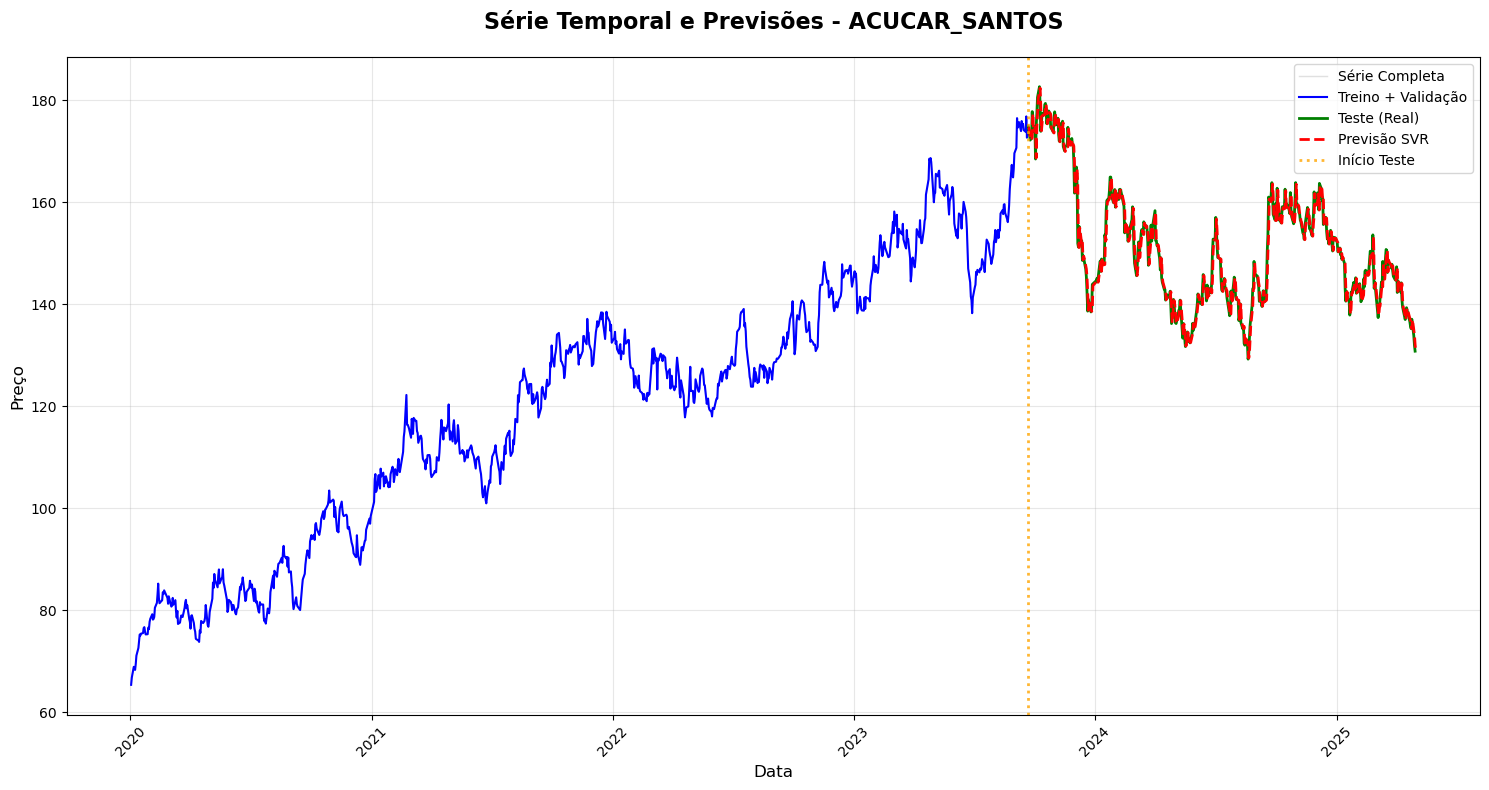

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


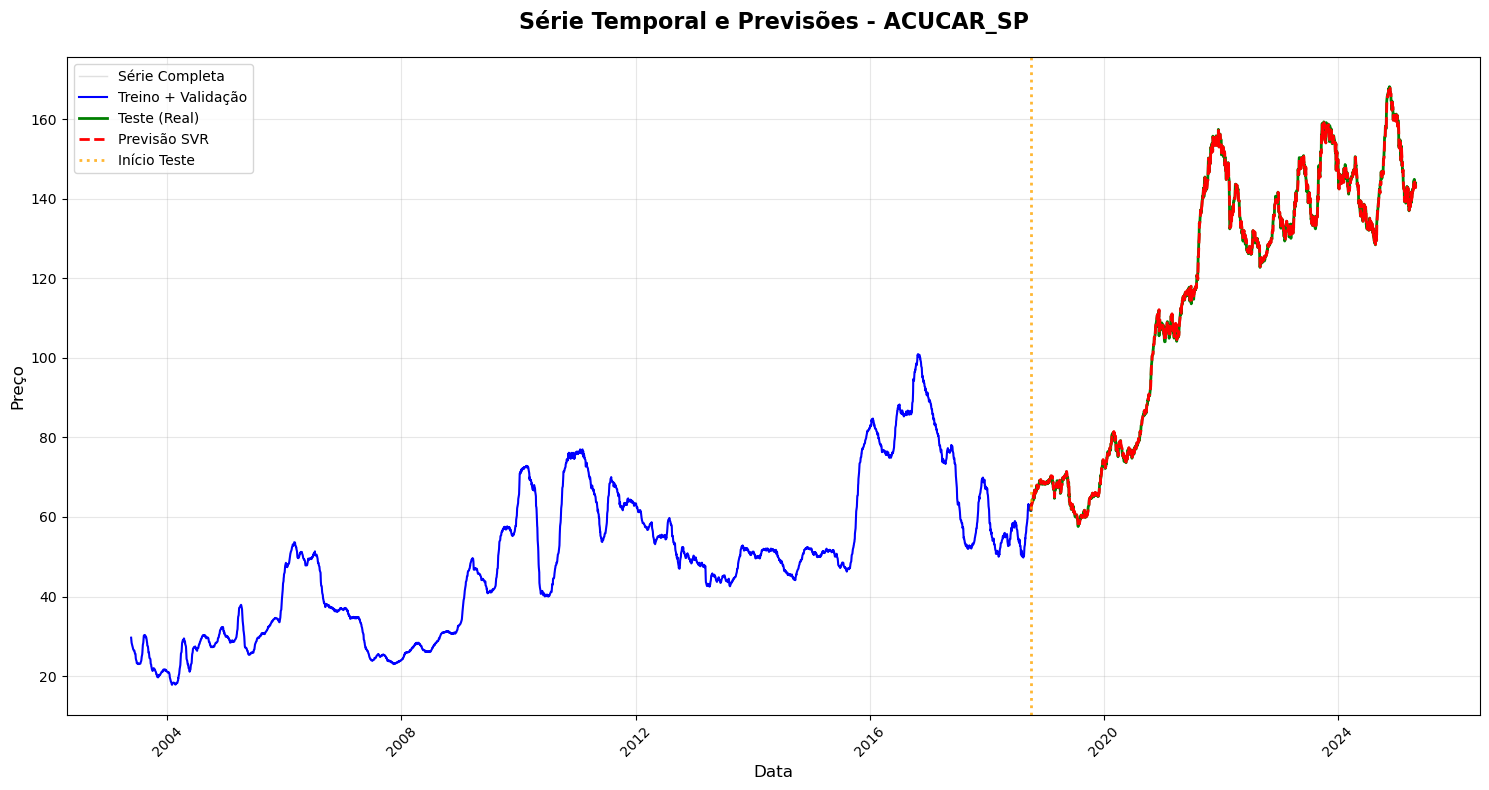

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


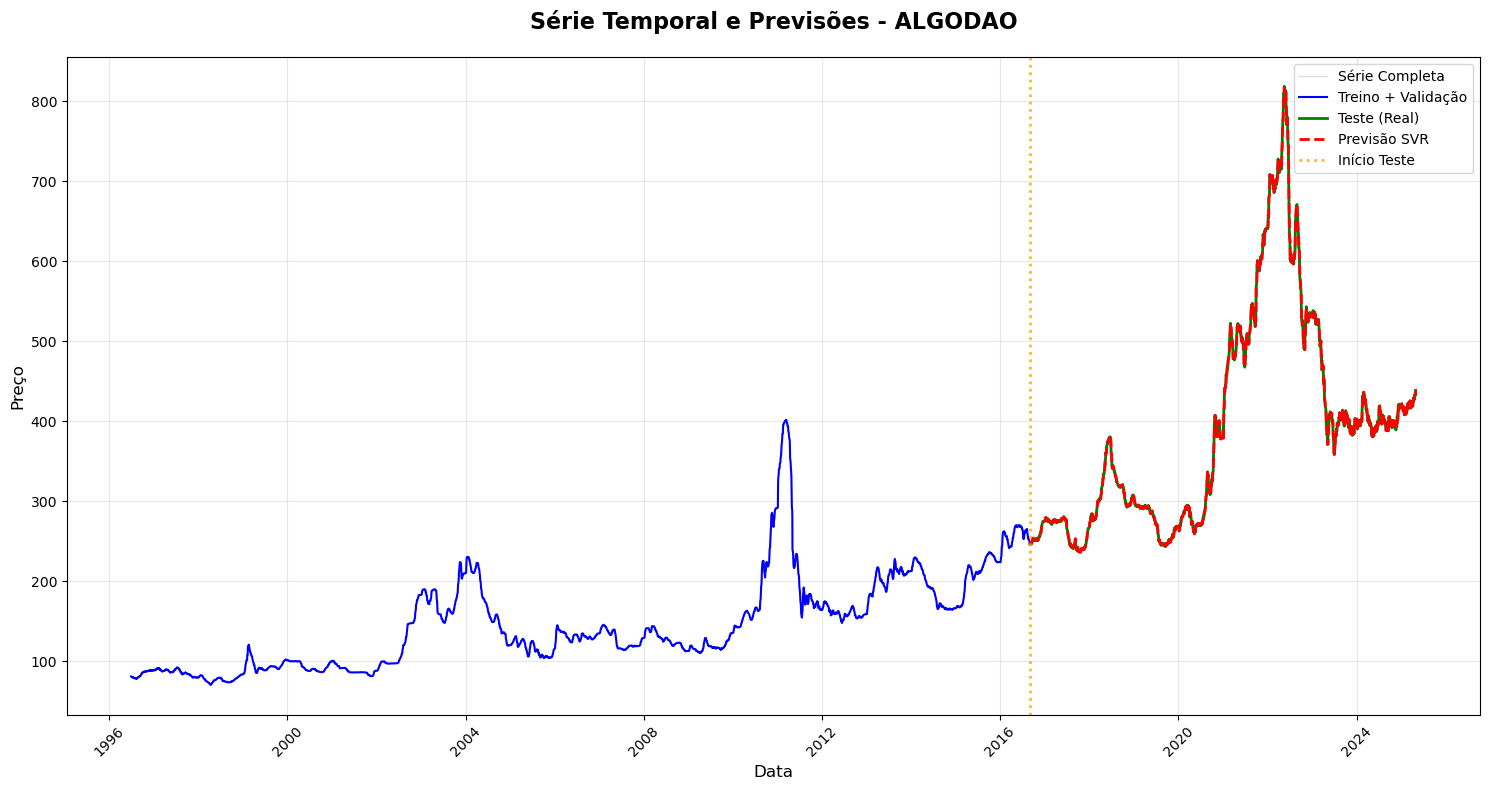

Gráfico exibido para: ALGODAO
--------------------------------------------------


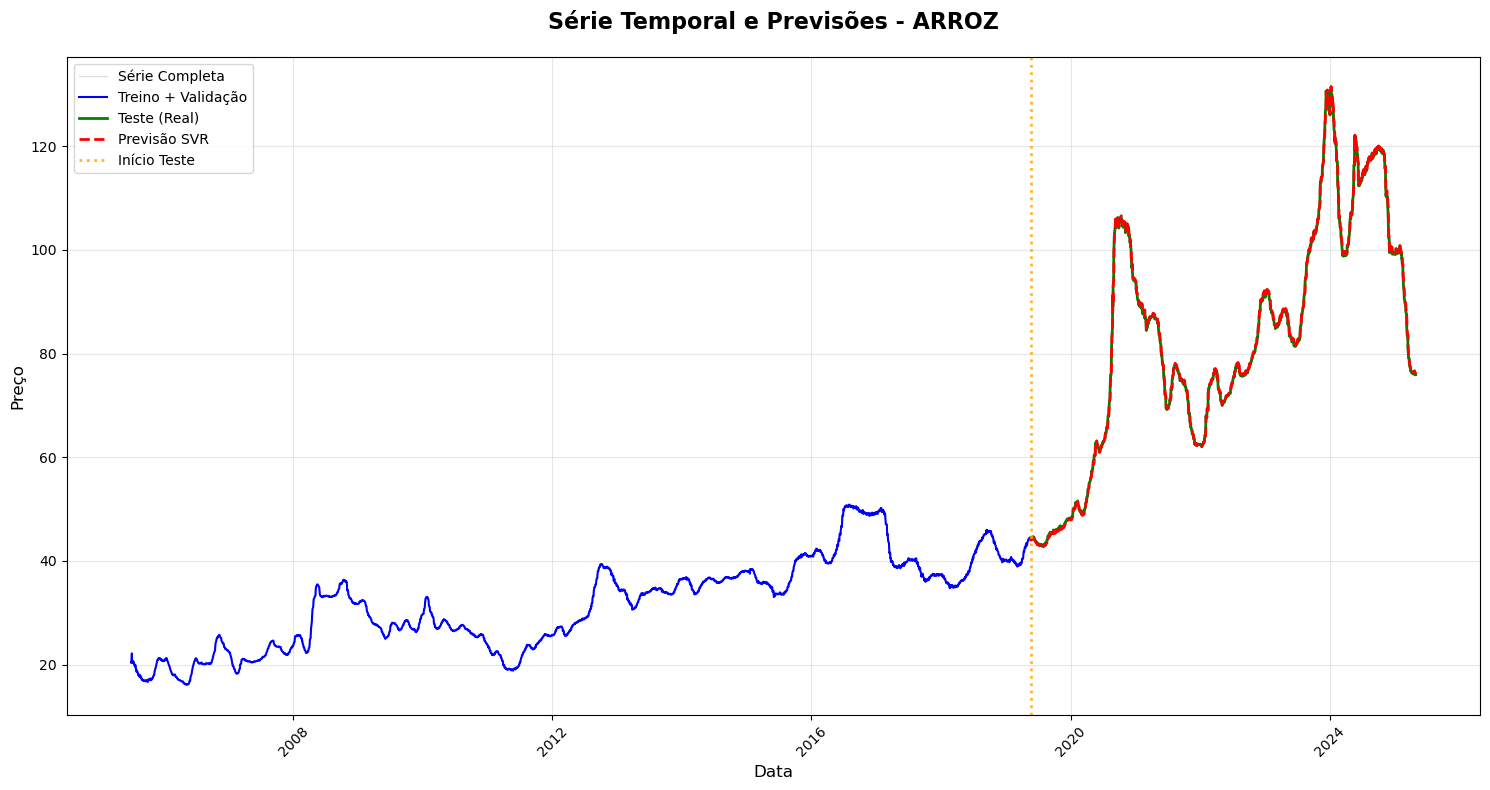

Gráfico exibido para: ARROZ
--------------------------------------------------


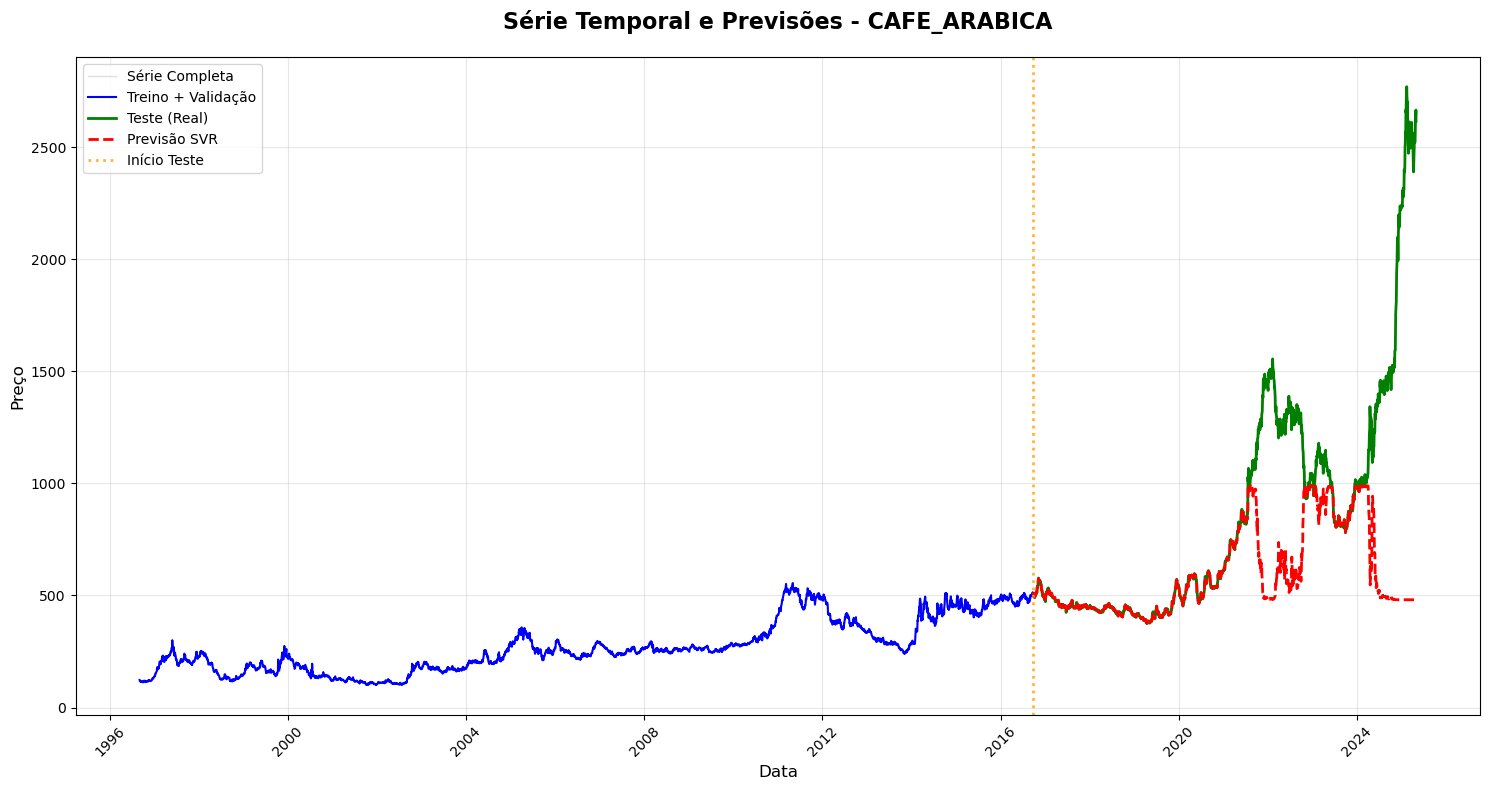

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


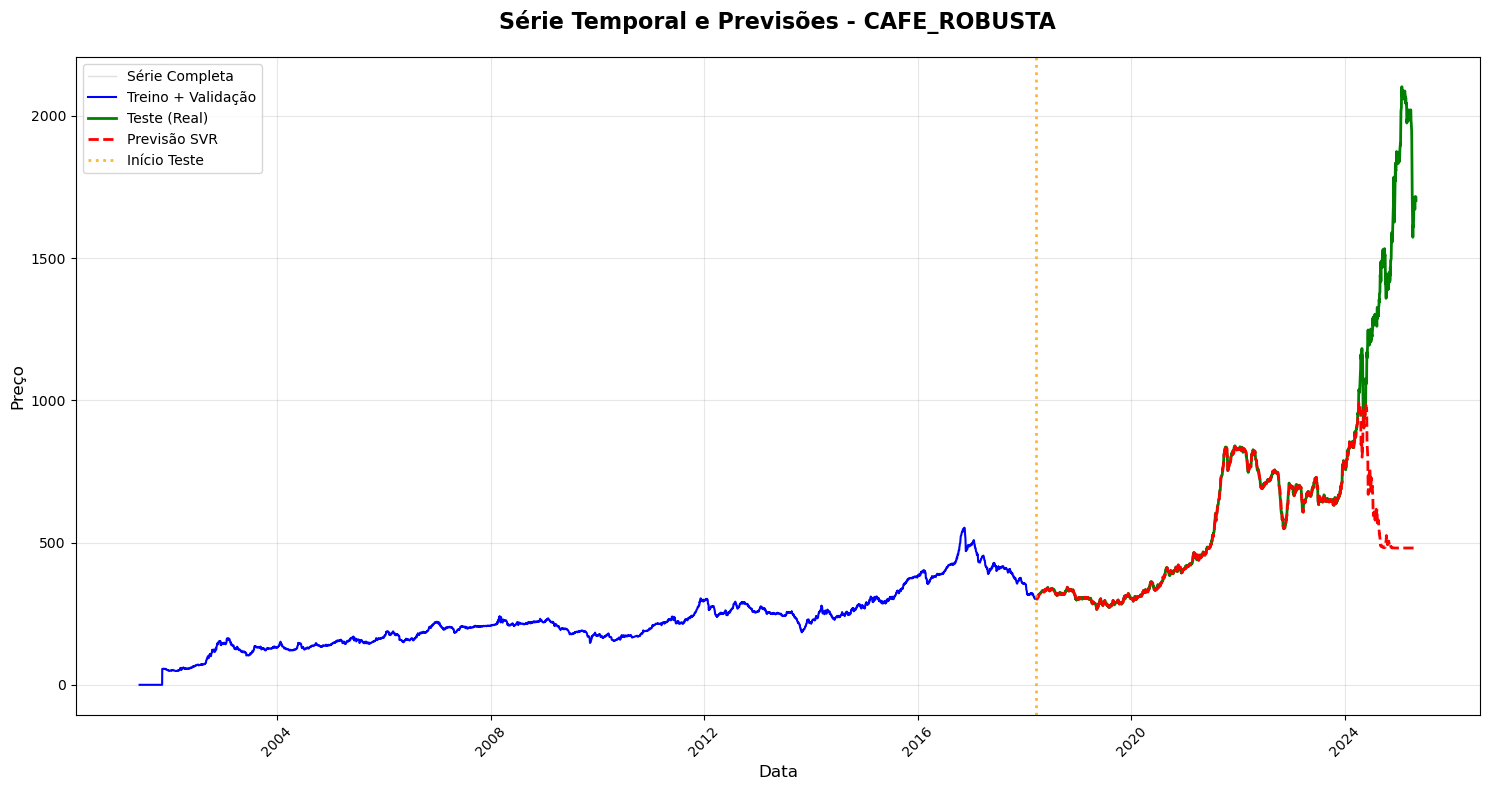

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


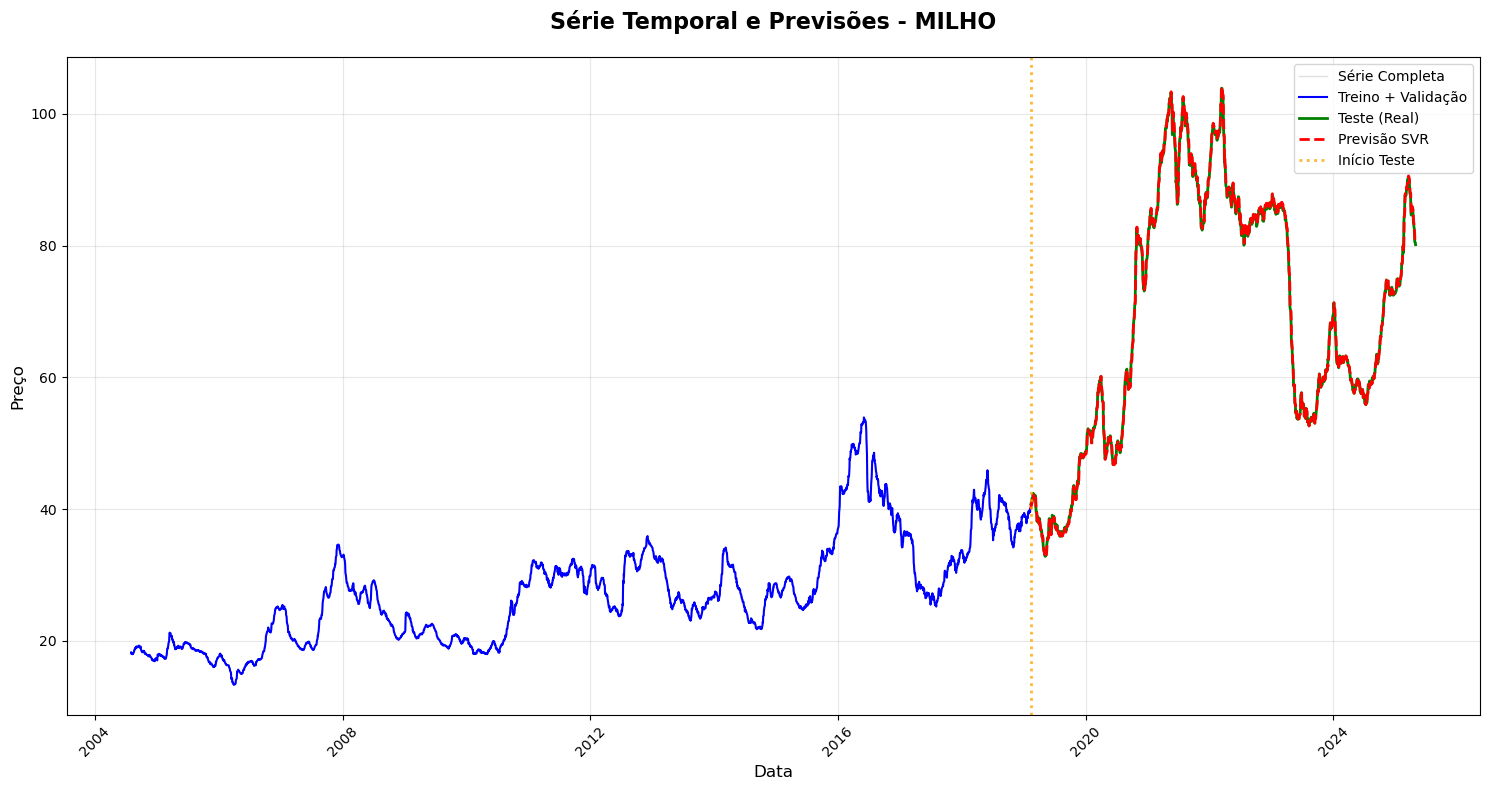

Gráfico exibido para: MILHO
--------------------------------------------------


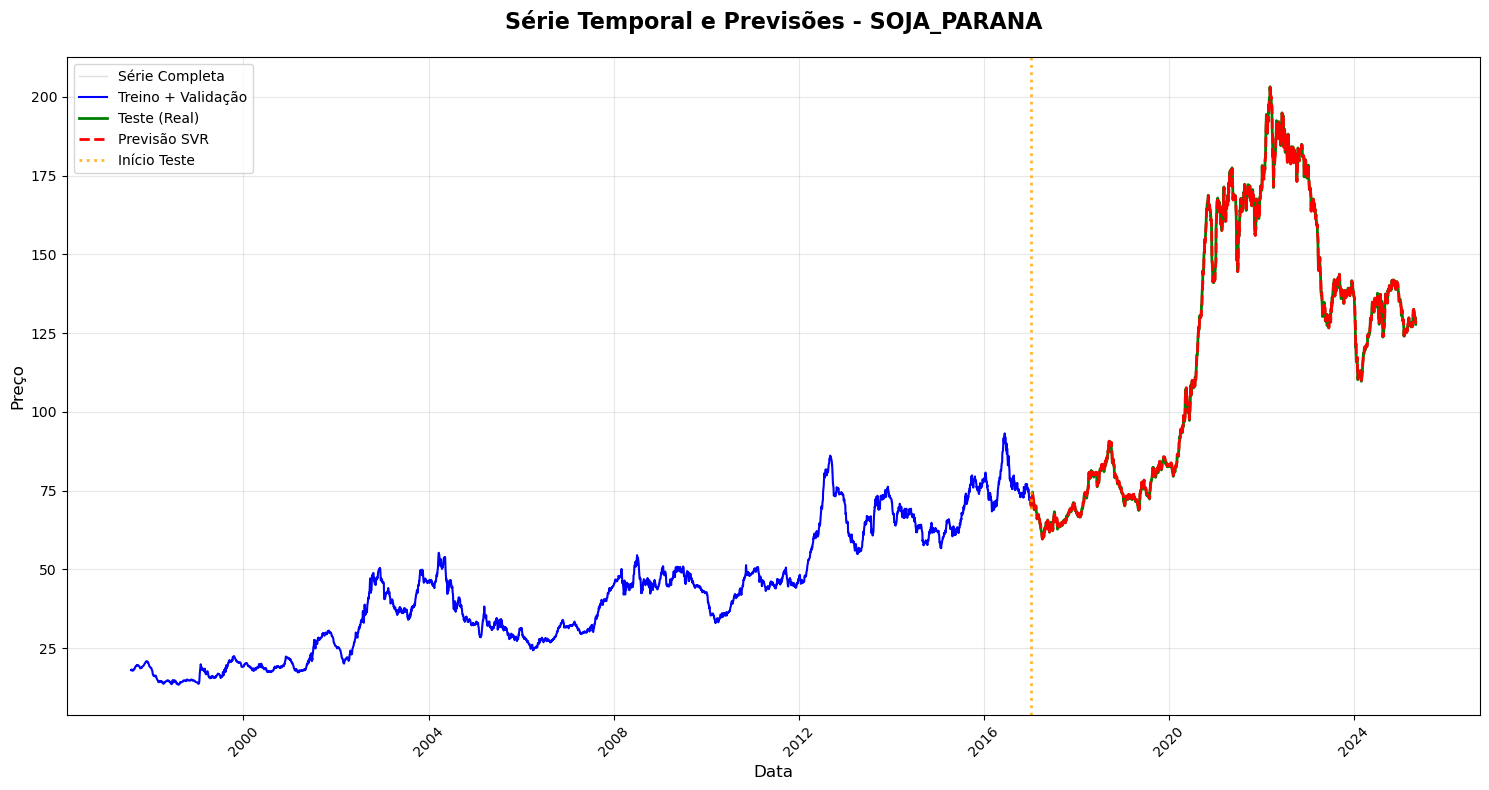

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


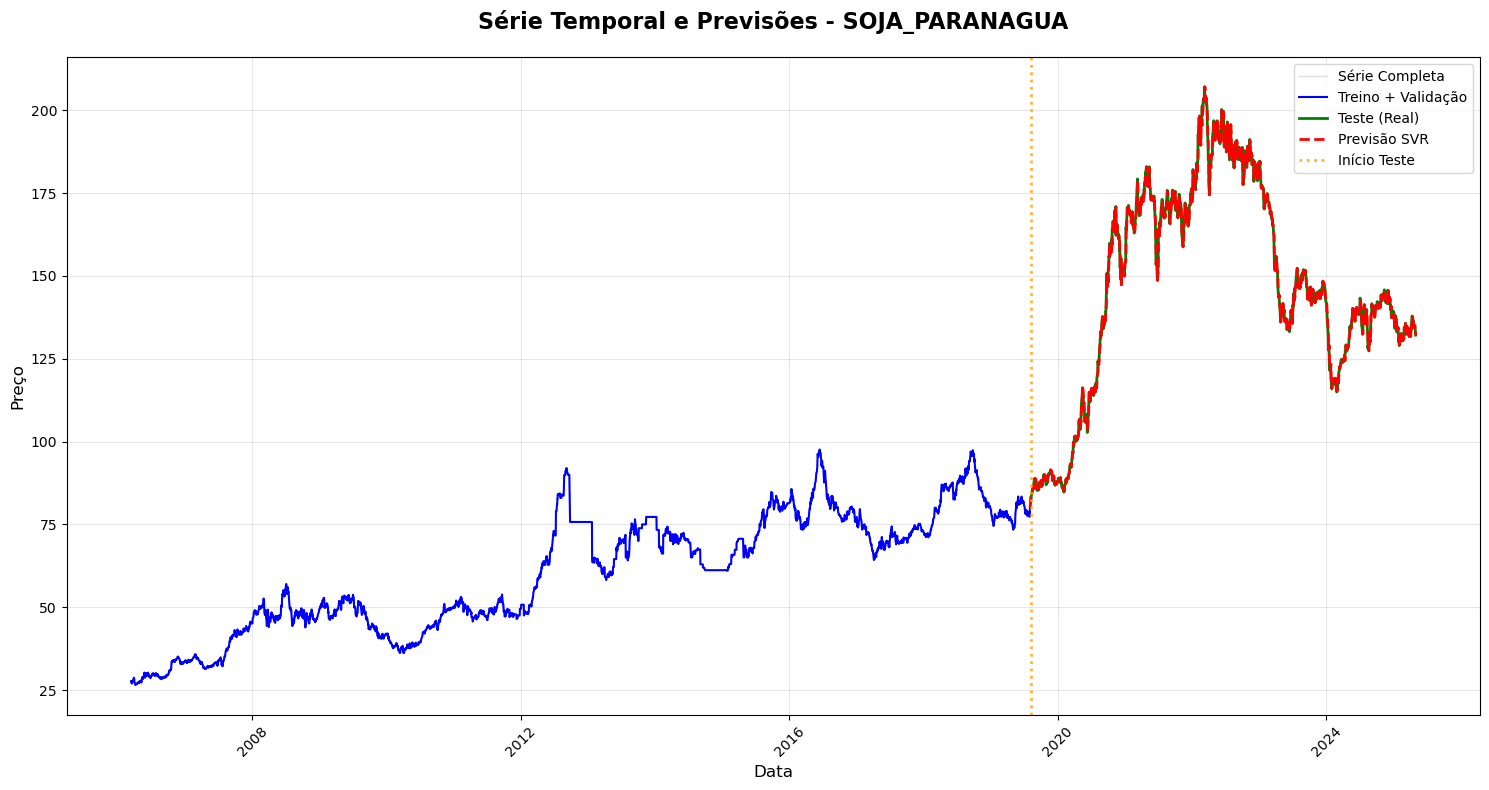

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


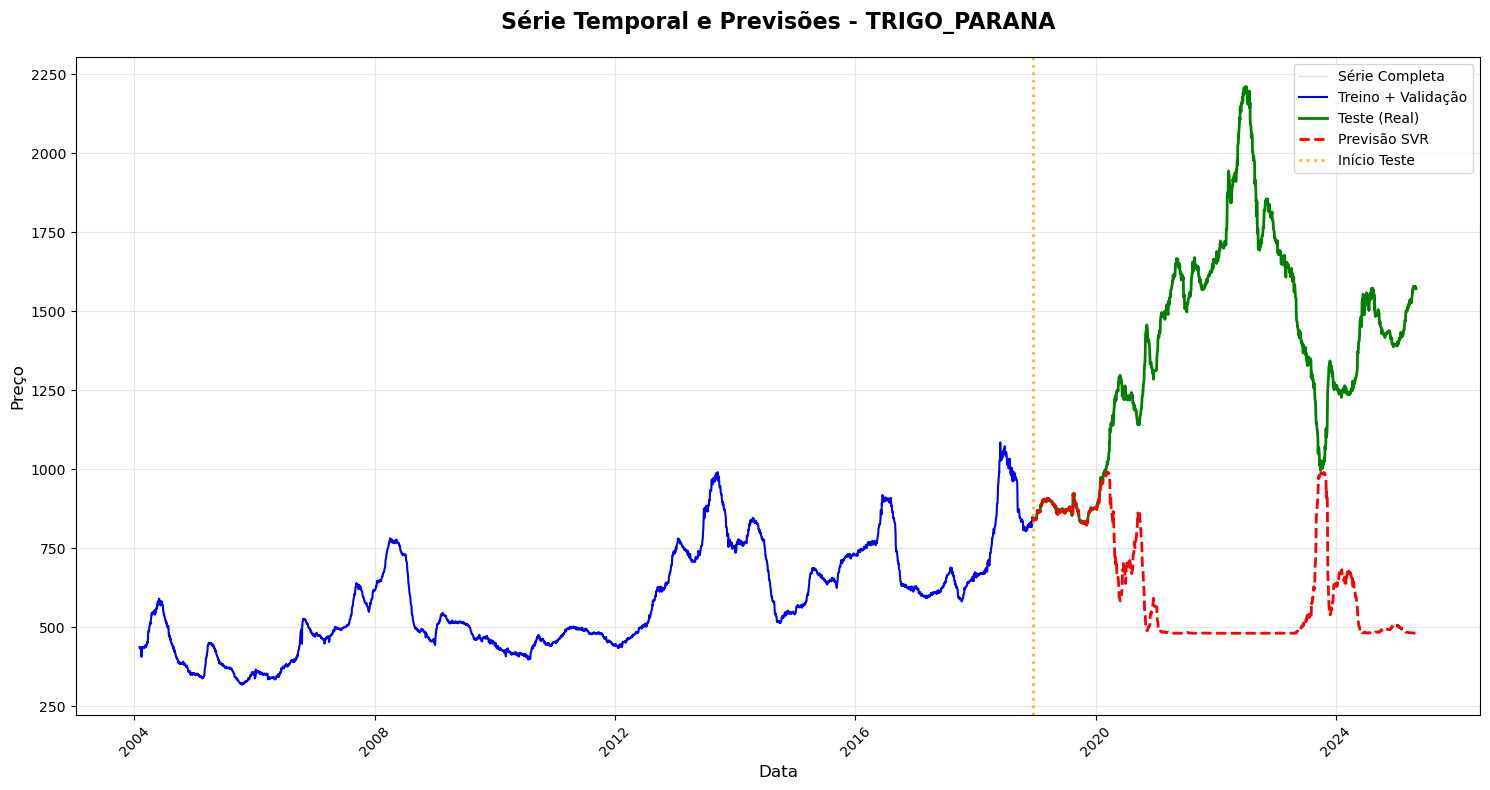

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


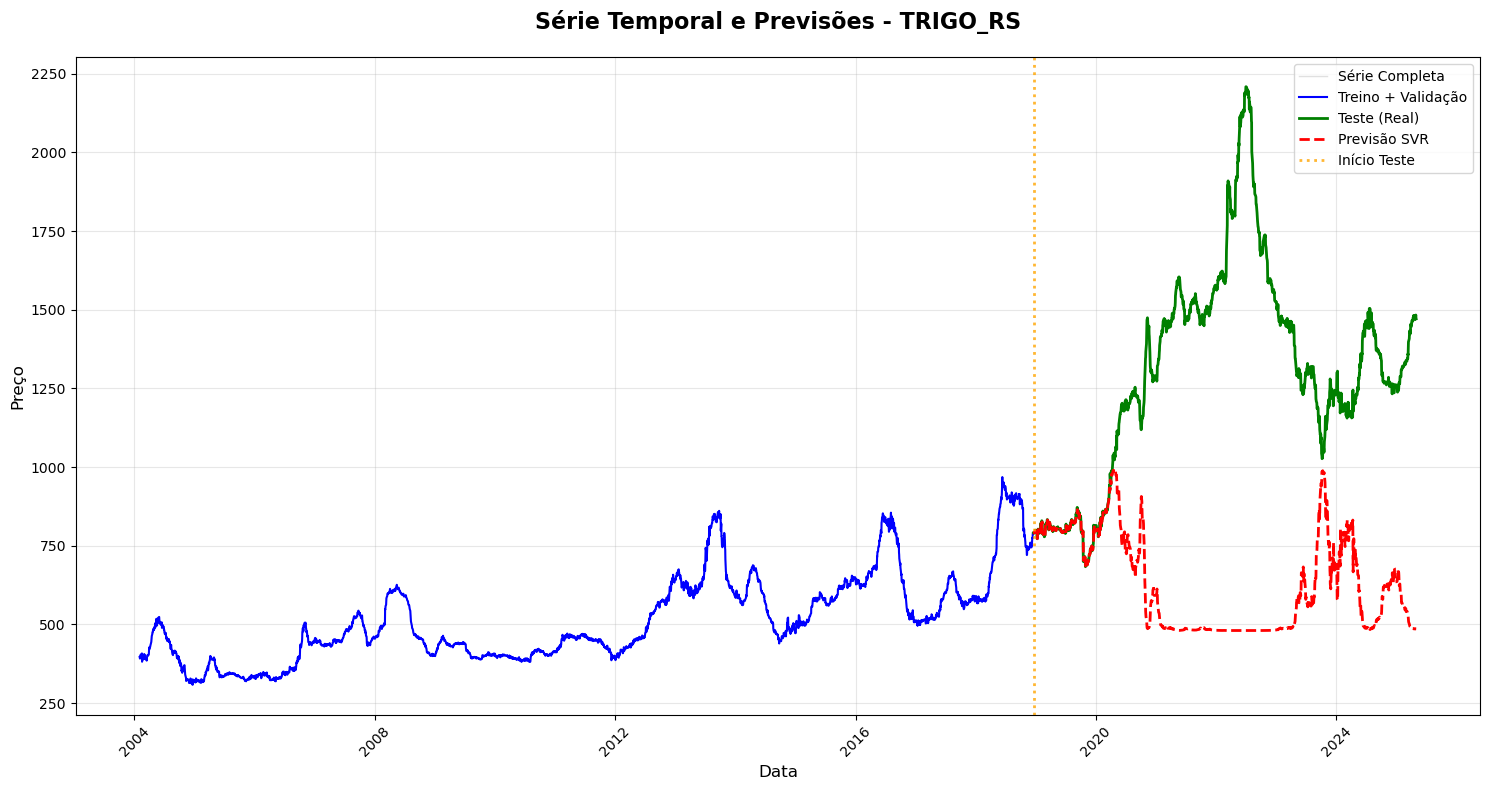

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [ ]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lightgray', alpha=0.7, linewidth=1, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='blue', linewidth=1.5, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='green', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['svr'], 
                color='red', linewidth=2, linestyle='--', label='Previsão SVR')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)